# Prepare Penn Treebank dataset

In [0]:
!pip install torchbearer

     |████████████████████████████████| 143kB 4.8MB/s 


In [0]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext import data
from torchtext import vocab
from torchtext import datasets

import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm

In [0]:
tokenize = lambda x: x.split()
TEXT = data.Field(sequential = True, tokenize = tokenize, lower = True, batch_first = True)
train_dataset, val_dataset, test_dataset = datasets.PennTreebank.splits(TEXT)
TEXT.build_vocab(train_dataset, vectors=vocab.GloVe(name='6B', dim=300))

vocab_size = len(TEXT.vocab)
word_embeddings = TEXT.vocab.vectors
print(vocab_size)
print(word_embeddings.size())
embeddings_length = 300
hidden_size = 256
batch_size = 32

downloading ptb.train.txt


ptb.train.txt: 5.10MB [00:00, 31.8MB/s]


downloading ptb.valid.txt


ptb.valid.txt: 400kB [00:00, 16.8MB/s]                   


downloading ptb.test.txt


ptb.test.txt: 450kB [00:00, 19.0MB/s]                   
.vector_cache/glove.6B.zip: 862MB [06:27, 2.23MB/s]                          
100%|█████████▉| 399843/400000 [00:38<00:00, 10397.97it/s]

10001
torch.Size([10001, 300])


In [0]:
train_iter, val_iter, test_iter = data.BPTTIterator.splits((train_dataset, val_dataset, test_dataset), batch_size = 32, bptt_len=30, repeat=False)

In [0]:
class LstmLangModel(nn.Module):
   def __init__(self, batch_size, hidden_size, vocab_size, embeddings_length, weights):
       super(LstmLangModel, self).__init__()
       self.batch_size = batch_size
       self.hidden_size = hidden_size
       self.vocab_size = vocab_size
       self.embed = nn.Embedding(vocab_size, embeddings_length)
       self.embed.weight.data.copy_(weights)
       self.lstm = nn.LSTM(embeddings_length, hidden_size, batch_first=True, num_layers=2)
       self.fc = nn.Linear(hidden_size, vocab_size)
   def forward(self, x, h):
       x = self.embed(x)
       output_seq, (h, c) = self.lstm(x, h)
       out = output_seq.reshape(output_seq.size(0)*output_seq.size(1), output_seq.size(2))
       out = self.fc(out)
       return out, (h, c)



In [0]:
vocab_size = len(TEXT.vocab)
word_embeddings = TEXT.vocab.vectors
print(vocab_size)
print(word_embeddings.size())
embeddings_length = 300
hidden_size = 256
batch_size = 32

10001
torch.Size([10001, 300])


In [0]:
model = LstmLangModel(batch_size, hidden_size, vocab_size, embeddings_length, word_embeddings)
model.eval()

LstmLangModel(
  (embed): Embedding(10001, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=10001, bias=True)
)

# Torchbear Section

In [0]:
!pip install adabound
import adabound

In [0]:
%%time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net_lstm = LstmLangModel(batch_size, hidden_size, vocab_size, embeddings_length, word_embeddings)
net_lstm = net_lstm.to(device)
criterion = nn.CrossEntropyLoss()
# optim = torch.optim.Adam(filter(lambda p: p.requires_grad, net_lstm.parameters()))
# optim = torch.optim.SGD(filter(lambda p: p.requires_grad, net_lstm.parameters()), lr=10, momentum=0.9, weight_decay=5e-4)
# optim = torch.optim.Adam(filter(lambda p: p.requires_grad, net_lstm.parameters()), lr=0.001,betas=(0.99, 0.999), weight_decay=5e-4, amsgrad=True)
optim = adabound.AdaBound(filter(lambda p: p.requires_grad, net_lstm.parameters()), lr=0.001, betas=(0.99, 0.999), final_lr=0.1, weight_decay=5e-4, amsbound=True)
num_epochs = 200
epoch_list = []
train_loss_lstm_list = []
train_perp_lstm_list = []
test_loss_lstm_list = []
test_perp_lstm_list = []

def detach(states):
   return [state.detach() for state in states]

for epoch in range(num_epochs):
   train_loss = 0
   states = (torch.zeros(2, batch_size, hidden_size).to(device),
             torch.zeros(2, batch_size, hidden_size).to(device))
   net_lstm.train()

   for i, batch in enumerate(train_iter):
       text = batch.text.to(device)
       labels = batch.target.to(device)
       text = text.permute(1, 0)
       labels = labels.permute(1, 0)

       optim.zero_grad()
       states = detach(states)
       outputs, states = net_lstm(text, states)
       loss = criterion(outputs, labels.reshape(-1))
       train_loss += loss.item()
       loss.backward()
       optim.step()
   avg_train_loss = train_loss / len(train_iter)
   perplexity = np.exp(avg_train_loss)
   print('Epoch [{}/{}],Train Loss: {:.4f}, Train Perplexity: {:5.2f}'.format(epoch + 1, num_epochs, avg_train_loss, perplexity))
   train_loss_lstm_list.append(avg_train_loss)
   train_perp_lstm_list.append(perplexity)


   ##########################################################################
   test_loss = 0
   states = (torch.zeros(2, batch_size, hidden_size).to(device),
             torch.zeros(2, batch_size, hidden_size).to(device))
   net_lstm.eval()

   for i, batch in enumerate(test_iter):
       text = batch.text.to(device)
       labels = batch.target.to(device)
       text = text.permute(1, 0)
       labels = labels.permute(1, 0)

      #  optim.zero_grad()
       states = detach(states)
       outputs, states = net_lstm(text, states)
       loss = criterion(outputs, labels.reshape(-1))
       test_loss += loss.item()
      #  loss.backward()
      #  optim.step()
   avg_test_loss = test_loss / len(test_iter)
   perplexity = np.exp(avg_test_loss)
   print('Epoch [{}/{}], Test Loss: {:.4f}, Test Perplexity: {:5.2f}'.format(epoch + 1, num_epochs, avg_test_loss, perplexity))
   test_loss_lstm_list.append(avg_test_loss)
   test_perp_lstm_list.append(perplexity)

   if epoch % 100 == 0:
       torch.save(net_lstm.state_dict(), r"./LSTM_" + str(epoch) + r".pth")
   
   if epoch == num_epochs - 1:
       torch.save(net_lstm.state_dict(), r"./LSTM_" + str(epoch) + r".pth")

100%|█████████▉| 399843/400000 [00:50<00:00, 10397.97it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha)


Epoch [1/200],Train Loss: 6.7334, Train Perplexity: 840.02
Epoch [1/200], Test Loss: 6.4899, Test Perplexity: 658.43
Epoch [2/200],Train Loss: 6.5548, Train Perplexity: 702.60
Epoch [2/200], Test Loss: 6.4783, Test Perplexity: 650.86
Epoch [3/200],Train Loss: 6.5458, Train Perplexity: 696.34
Epoch [3/200], Test Loss: 6.4656, Test Perplexity: 642.64
Epoch [4/200],Train Loss: 6.5217, Train Perplexity: 679.75
Epoch [4/200], Test Loss: 6.4260, Test Perplexity: 617.70
Epoch [5/200],Train Loss: 6.4760, Train Perplexity: 649.40
Epoch [5/200], Test Loss: 6.3998, Test Perplexity: 601.75
Epoch [6/200],Train Loss: 6.4507, Train Perplexity: 633.16
Epoch [6/200], Test Loss: 6.3807, Test Perplexity: 590.35
Epoch [7/200],Train Loss: 6.4303, Train Perplexity: 620.35
Epoch [7/200], Test Loss: 6.3587, Test Perplexity: 577.47
Epoch [8/200],Train Loss: 6.4017, Train Perplexity: 602.87
Epoch [8/200], Test Loss: 6.3267, Test Perplexity: 559.31
Epoch [9/200],Train Loss: 6.3685, Train Perplexity: 583.20
Epoch

In [0]:
import pandas as pd

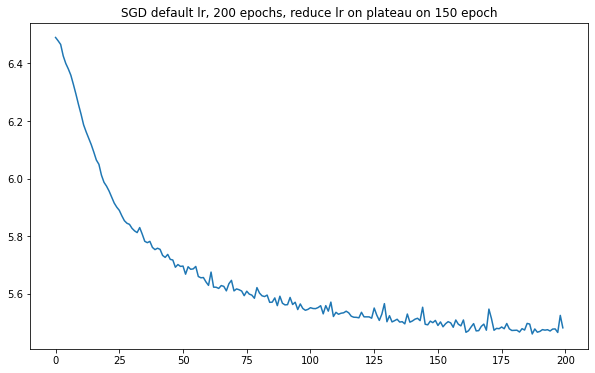

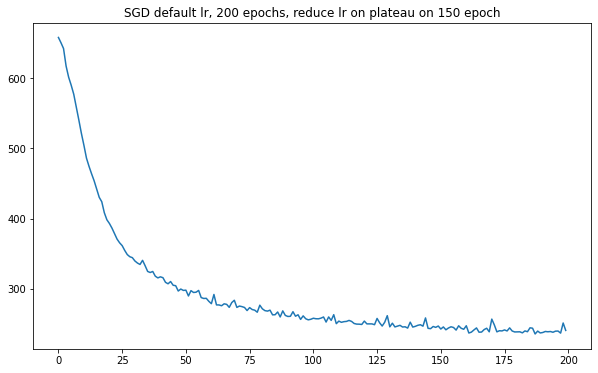

In [0]:
frame = pd.DataFrame(zip(train_loss_lstm_list,train_perp_lstm_list, test_loss_lstm_list,test_perp_lstm_list))
frame.columns = ['train_loss','train_perp','test_loss','test_perp']
frame.to_csv('AMSBound_test_2_LSTM.csv')

plt.figure(figsize=(10,6))
plt.title('SGD default lr, 200 epochs, reduce lr on plateau on 150 epoch')
plt.plot(range(200),frame['test_loss'])


plt.figure(figsize=(10,6))
plt.title('SGD default lr, 200 epochs, reduce lr on plateau on 150 epoch')
plt.plot(range(200),frame['test_perp'])